Install Dependencies

In [1]:
!pip install kaggle

!pip install numpy==1.15.0

!pip install catboost

    100% |████████████████████████████████| 13.9MB 2.2MB/s 
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6


    100% |████████████████████████████████| 55.5MB 671kB/s 


In [0]:
import pandas as pd

import numpy as np

from catboost import CatBoostRegressor, Pool

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from sklearn.svm import NuSVR, SVR

from sklearn.kernel_ridge import KernelRidge

import matplotlib.pyplot as plt




**Import Dataset from kaggle**

In [3]:
from google.colab import files

uploaded = files.upload()

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/kaggle/kaggle.json

Saving kaggle.json to kaggle.json
chmod: cannot access '/root/kaggle/kaggle.json': No such file or directory


In [4]:
#import all competitions from Kaggle

!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2479            True  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      10012            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4073            True  
imagenet-object-localization-challenge         2029-12-31 07:00:00  Research         Knowledge         35           False  
competitive-data-science-predict-future-sales  2019-12-31 23:59:00  Playground           Kudos       2479           False  
two-sigma-financial-news                       2019-07-15 23:59:00  Featured          $100,000       2927           False  
LANL-Ear

In [6]:
#download earthquake data

!kaggle competitions download -c LANL-Earthquake-Prediction

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 28.5MB/s]
 99% 239M/242M [00:02<00:00, 109MB/s] 
100% 242M/242M [00:02<00:00, 90.8MB/s]
100% 2.02G/2.03G [00:35<00:00, 13.5MB/s]
100% 2.03G/2.03G [00:35<00:00, 62.1MB/s]


In [7]:
!ls

sample_data  sample_submission.csv  test.zip  train.csv.zip


In [8]:
!unzip train.csv.zip
# !unzip test.zip
!ls

Archive:  train.csv.zip
  inflating: train.csv               
sample_data  sample_submission.csv  test.zip  train.csv  train.csv.zip


In [0]:
# get data
train = pd.read_csv("train.csv", nrows=60000000, dtype={'acoustic_data':np.int16, 'time_to_failure':np.float64})

In [10]:
train.head(10)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


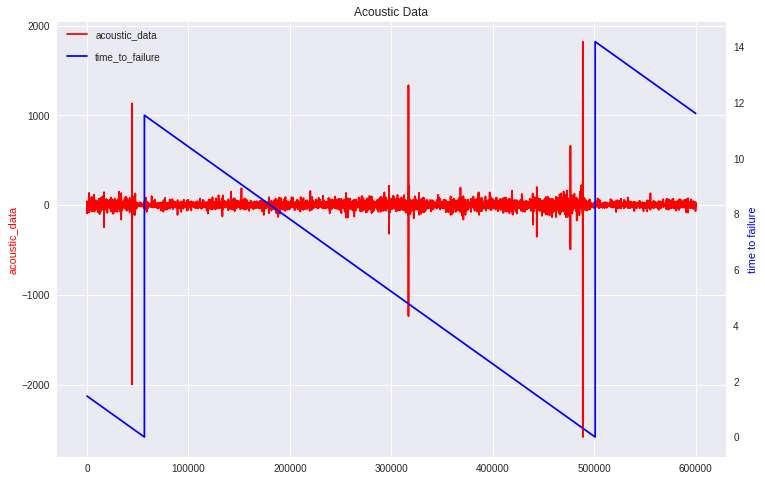

In [11]:
#visualize the data

train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]

def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df,title="Acoustic Data"):
  fig, ax1 = plt.subplots(figsize=(12,8))
  plt.title(title)
  
  plt.plot(train_ad_sample_df, color='r')
  ax1.set_ylabel('acoustic_data', color='r')
  plt.legend(['acoustic_data'], loc=(0.01,0.95))
  
  ax2 = ax1.twinx()
  plt.plot(train_ttf_sample_df, color='b')
  ax2.set_ylabel('time to failure', color='b')
  plt.legend(['time_to_failure'], loc=(0.01, 0.9))
  plt.grid()
  
  
plot_acc_ttf_data(train_ad_sample_df,train_ttf_sample_df)

del train_ad_sample_df
del train_ttf_sample_df
  
  

**Feature Engineering**

In [0]:
#generate new statistical features

def gen_features(X):
  strain = []
  strain.append(X.mean()) #1st moment -mean
  strain.append(X.std())  #2st moment -variance/std dev
  strain.append(X.min())  
  strain.append(X.skew()) #3rd moment -skew
  strain.append(X.kurtosis()) #4th moment -kurtosis
#   strain.append(X.quantile(X,0.01)) 
  return pd.Series(strain)


# train.describe()
  
  

In [0]:
#Add those satistical features to dataset

train = pd.read_csv('train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data':np.int16, 'time_to_failure':np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()

for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
  


In [14]:
X_train.describe()

,0,1,2,3,4
count,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000
mean,4.519475,6.547788,-149.190942,0.125830,68.297997
std,0.256049,8.503939,265.087984,0.477901,70.532565
min,3.596313,2.802720,-5515.000000,-4.091826,0.648602
25%,4.349497,4.478637,-154.000000,-0.040779,28.090227
50%,4.522147,5.618798,-111.000000,0.085620,45.816625
75%,4.693350,6.880904,-79.000000,0.253930,78.664202
max,5.391993,153.703569,-15.000000,4.219429,631.158927


In [15]:
train_pool = Pool(X_train, y_train)
m = CatBoostRegressor(iterations= 10000, loss_function='MAE', boosting_type='Ordered')
m.fit(X_train, y_train, silent=True)
m.best_score_

{'learn': {'MAE': 1.853795086185162}}

In [16]:
#build SVM sklearn + Grid search
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
              'C':[0.1,0.2,0.25,0.5,1,1.5,2]}]

reg1 = GridSearchCV(SVR(kernel='rbf', tol=0.01), parameters, cv=5, scoring='neg_mean_absolute_error')
reg1.fit(X_train_scaled,y_train.values.flatten())

y_pred1 = reg1.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(reg1.best_score_))

print(reg1.best_params_)

Best CV score: -2.3460
{'C': 2, 'gamma': 0.1}
